# SETTINGS

In [ ]:
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import tensorflow
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import random

In [ ]:
torch.manual_seed(0)

# LOAD DATA

In [ ]:
class MnistDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, digits, labels, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.digits = digits
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.digits)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return self.digits[idx], self.labels[idx]

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
dataset = tensorflow.keras.datasets.mnist.load_data()

In [ ]:
(x_train, y_train), (x_test, y_test) = tensorflow.keras.datasets.mnist.load_data()

mnist_digits_train = np.expand_dims(x_train, -1).astype("float32") / 255
mnist_digits_test = np.expand_dims(x_test, -1).astype("float32") / 255

mnist_digits_train = torch.tensor(mnist_digits_train)
mnist_digits_test = torch.tensor(mnist_digits_test)

mnist_labels_train = torch.tensor(y_train)
mnist_labels_test = torch.tensor(y_test)

In [ ]:
train_data = MnistDataset(mnist_digits_train, mnist_labels_train)
test_data = MnistDataset(mnist_digits_test, mnist_labels_test) 

In [ ]:
batch_size = 128

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

# MODEL BUILDING

In [ ]:
# Define the encoder network
class Encoder(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=256, latent_dim=2):
        super().__init__()

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.mean = nn.Linear(hidden_dim, latent_dim)
        self.log_std = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        mean = self.mean(x)
        log_std = torch.exp(self.log_std(x))
        return mean, log_std

In [ ]:
# Define the decoder network
class Decoder(nn.Module):
    def __init__(self, latent_dim=2, hidden_dim=256, output_dim=784):
        super().__init__()

        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.mean = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        batch_dim = x.shape[0]
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        mean = self.mean(x)
        return mean


In [ ]:
# Define the VAE
class VAE(nn.Module):

    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.posterior_std = nn.Parameter(torch.tensor(1.0), requires_grad=True)
        self.device = device
        
    def forward(self, x):
        # Encode the input data
        # z = z_mean + torch.exp(0.5 * z_log_std)*self.N.sample(z_mean.shape)
        z_mean, z_log_std = self.encoder(x)
        self.batch_size = z_mean.shape[0]
        self.z_mean = z_mean
        self.z_log_var = z_log_std**2

        cov = torch.einsum("bi,ij -> bij", self.z_log_var, torch.eye(2, device=device))
        z_latent = torch.distributions.MultivariateNormal(z_mean, cov).sample()

        z_prior = self.make_prior(2, self.batch_size ).sample()

        # Decode the latent representation
        posterior_mean = self.decoder(z_latent)

        return z_latent, z_prior, posterior_mean
    
    def vae_loss(self, z_latent, z_prior, posterior_mean, kl_loss_function, batch_data):

        # maybe we will use this one
        #kl_loss = kl_loss_function(z_latent, z_prior).sum(axis=1)

        #kl loss implementation
        kl_loss = -0.5 * (1 + self.z_log_var - torch.square(self.z_mean) - torch.exp(self.z_log_var))
        kl_loss = kl_loss.sum(axis=1)


        cov = model.posterior_std**2 * torch.eye(784, device=device)
        likelihood_loss = torch.distributions.MultivariateNormal(posterior_mean, cov).log_prob(torch.flatten(batch_data, start_dim = 1).to(device))

        elbo = torch.mean(likelihood_loss - kl_loss)

        # Return the negative elbo
        return -elbo

    def make_prior(self, dim_latent_space, batch_size):
        mean = torch.zeros(batch_size, dim_latent_space, device=device)
        cov = torch.eye(dim_latent_space, device=device).repeat(batch_size, 1, 1)
        return torch.distributions.MultivariateNormal(mean, cov)


# TRAINING

In [ ]:
# Create the encoder and decoder networks
encoder = Encoder()
decoder = Decoder()

# Create the VAE
model = VAE(encoder, decoder,device).to(device)

In [ ]:
%%time

num_epochs=60
latent_dim = 2
# Define the optimizer and learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
kl_loss = nn.KLDivLoss(reduction="none").to(device)
train_loss_list = []
test_loss_list = []
# Train the VAE
for epoch in range(1, num_epochs+1):

    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        
        # Run VAE
        z_latent, z_prior, posterior_mean = model(data)
        
        # Compute loss
        total_loss = model.vae_loss(z_latent, z_prior, posterior_mean, kl_loss, data)
        total_loss.backward()
        train_loss += total_loss.item()
        optimizer.step()

        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tposterior_std: {:f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                total_loss.item() / len(data),
                model.posterior_std.item()))
        
    if epoch==1:
      torch.save(model.state_dict(), f"model_latent{latent_dim}_epoch_{epoch}.model")
    if epoch==5:
      torch.save(model.state_dict(), f"model_latent{latent_dim}_epoch_{epoch}.model")
    if epoch==25:
      torch.save(model.state_dict(), f"model_latent{latent_dim}_epoch_{epoch}.model")
    if epoch==50:
      torch.save(model.state_dict(), f"model_latent{latent_dim}_epoch_{epoch}.model")
    
    train_loss /=  len(train_loader.dataset)
    print('====> Epoch: {} Average Train loss: {:.4f}'.format(epoch, train_loss))
    train_loss_list.append(train_loss)

    model.eval()
    test_loss = 0
    for batch_idx, (data, _) in enumerate(test_loader):
        data = data.to(device)        
        # Run VAE
        z_latent, z_prior, posterior_mean = model(data)
        
        # Compute loss
        total_loss = model.vae_loss(z_latent, z_prior, posterior_mean, kl_loss, data)
        test_loss += total_loss.item()
    
    test_loss /=  len(test_loader.dataset)
    print('====> Epoch: {} Average Test loss: {:.4f}'.format(epoch, test_loss))
    print()
    test_loss_list.append(test_loss)

torch.save(model.state_dict(), f"model_latent{latent_dim}_epoch_{epoch}.model")

Train Epoch: 1 [0/60000 (0%)]	Loss: 6.007665	posterior_std: 0.999000
Train Epoch: 1 [25600/60000 (43%)]	Loss: 4.522323	posterior_std: 0.790648
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.776086	posterior_std: 0.562691
====> Epoch: 1 Average Train loss: 4.1600
====> Epoch: 1 Average Test loss: 2.0641

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.052008	posterior_std: 0.479954
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.309569	posterior_std: 0.279900
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.308970	posterior_std: 0.260185
====> Epoch: 2 Average Train loss: 0.6804
====> Epoch: 2 Average Test loss: 0.3568

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.388009	posterior_std: 0.256392
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.591464	posterior_std: 0.258396
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.323812	posterior_std: 0.254749
====> Epoch: 3 Average Train loss: 0.3449
====> Epoch: 3 Average Test loss: 0.3249

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.343833	posterior_std: 0.254511
Train Epoch: 4 [25600/60000 

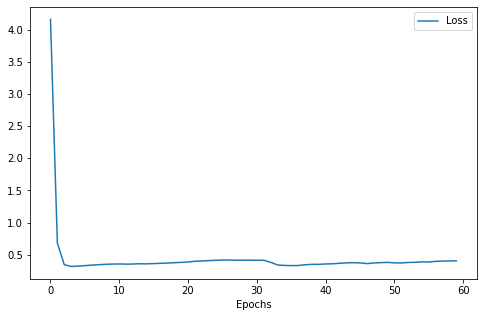

In [ ]:
dataframe = pd.DataFrame(train_loss_list, columns=["Loss"])
dataframe["Epochs"] = dataframe.index.values
dataframe.plot(x="Epochs", y="Loss", figsize=(8,5))

# 2) What might be the reason if we obtain good reconstructed but bad generated digits? 

In [ ]:
def reconstruct_digit(model, data_point):
  _, _, posterior_mean = model(data_point)
  posterior_std = model.posterior_std
  cov = torch.eye(784, device=model.device)
  reconstructed_data = torch.distributions.MultivariateNormal(torch.zeros_like(posterior_mean),cov).sample() @ (posterior_std*cov) + posterior_mean
  reconstructed_data = reconstructed_data.cpu().detach().numpy().reshape(-1, 1).reshape(28,28)
  return reconstructed_data

In [ ]:
def generate_digit(model, latent_data):
  decoder = model.decoder
  posterior_mean = decoder(latent_data)
  posterior_std = model.posterior_std
  cov = torch.eye(784, device=model.device)
  generated_data = torch.distributions.MultivariateNormal(torch.zeros_like(posterior_mean),cov).sample() @ (posterior_std*cov) + posterior_mean
  generated_data = generated_data.cpu().detach().numpy().reshape(-1, 1).reshape(28,28)
  return generated_data

In [ ]:
latent_data = torch.distributions.MultivariateNormal(torch.zeros(2, device=model.device), torch.eye(2,device=model.device)).sample()

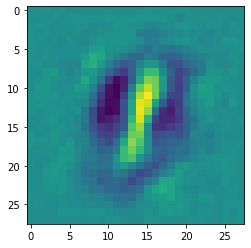

In [ ]:
plt.imshow(generate_digit(model, latent_data))

In [ ]:
for _, (a, _) in enumerate(train_loader):
  break
a.shape
data = a[0].unsqueeze(0).to(device)
data.shape

torch.Size([1, 28, 28, 1])

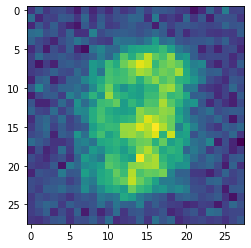

In [ ]:
plt.imshow(reconstruct_digit(model, data))

# 3) Train the VAE (training set) and do the following experiments (test set) after the 1st epoch, the 5th epoch, the 25th epoch, the 50th epoch, and after the optimisation converged:

In [ ]:
%%time
# Test the VAE
models = [x for x in os.listdir() if ".model" in x]

encoder = Encoder()
decoder = Decoder()

reconstructed_images ={}

for model_path in models:
    reconstructed_images[model_path] ={}

    z_latent_list =[]
    labels_list = []
    model = VAE(encoder, decoder,device).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    to_be_reconstructed = torch.tensor([], device =model.device)
    test_loss = 0
    for batch_idx, (data, labels) in enumerate(test_loader):
        data = data.to(device)
        labels_list.extend(labels.cpu().detach().numpy())        

        # Run VAE
        z_latent, _, _ = model(data)
        z_latent_list.extend(z_latent.cpu().detach().numpy())

    reconstructed_images[model_path]["latent_representation"] = np.array(z_latent_list)
    reconstructed_images[model_path]["labels"] = np.array(labels_list)

    #PART B
    recon_images_list = []
    original_images_list = []

    for index in range(15):
        data_point = data[index]
        original_images_list.append(data_point.squeeze(2).cpu().detach().numpy())
        data_point = data_point.unsqueeze(0)
        recon_images_list.append(reconstruct_digit(model, data_point))

    reconstructed_images[model_path]["recon_images"] = recon_images_list
    reconstructed_images[model_path]["original_images"] = original_images_list

    #PART C
    generated_images_list = []
    for index in range(15):
        latent_data = torch.distributions.MultivariateNormal(torch.zeros(2, device=model.device), torch.eye(2,device=model.device)).sample()
        generated_images_list.append(generate_digit(model, latent_data))
    
    reconstructed_images[model_path]["generated_images"] = generated_images_list

CPU times: user 1.99 s, sys: 21.1 ms, total: 2.01 s
Wall time: 2.01 s


In [ ]:
def plot_img_data(imgs, title, epoch, latent_dim):
    fig = plt.figure(figsize=(18, 2))
    columns = 15
    fig.suptitle(f'{title} (Epoch: {epoch}, Latent Dim:{latent_dim})', fontsize=20)
    for i, img in enumerate(imgs):
        img = img#.cpu().detach().numpy()

        fig.add_subplot(1, 15, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

    fig.savefig(f'{title}_{epoch}_{latent_dim}.png')

## a) Plot the latent representation, i.e., encode the test set and mark the different classes.

In [ ]:
def plot_label_clusters(z_mean, labels):
    # display a 2D plot of the digit classes in the latent space
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

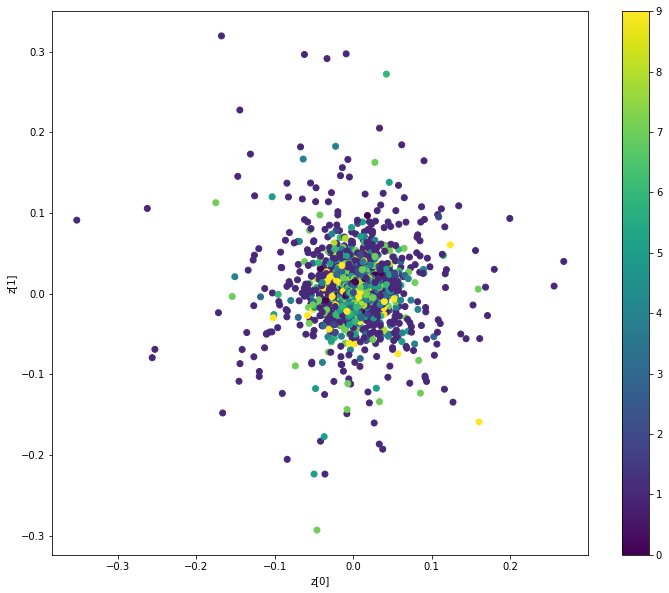

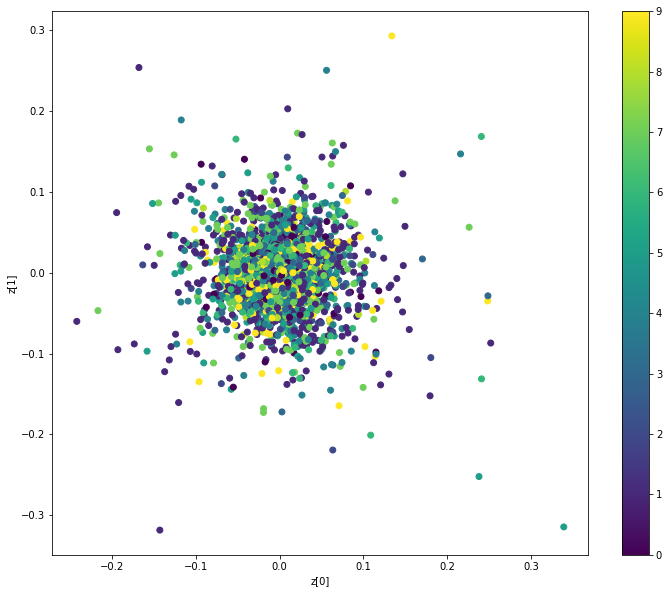

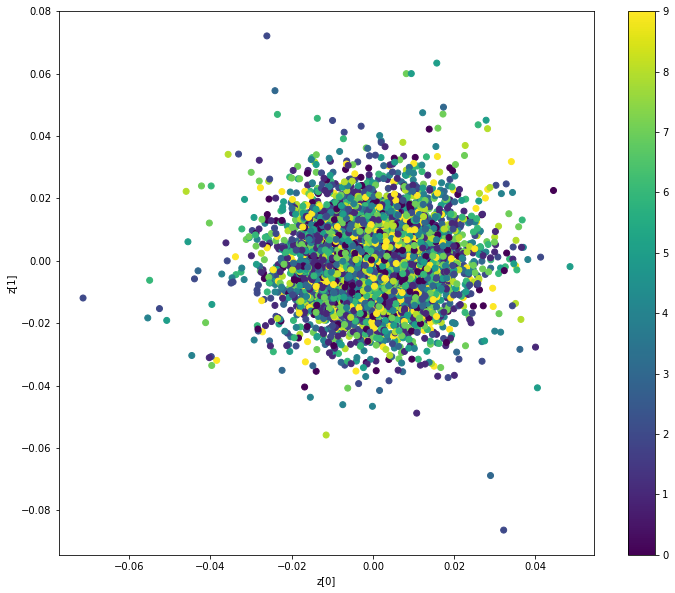

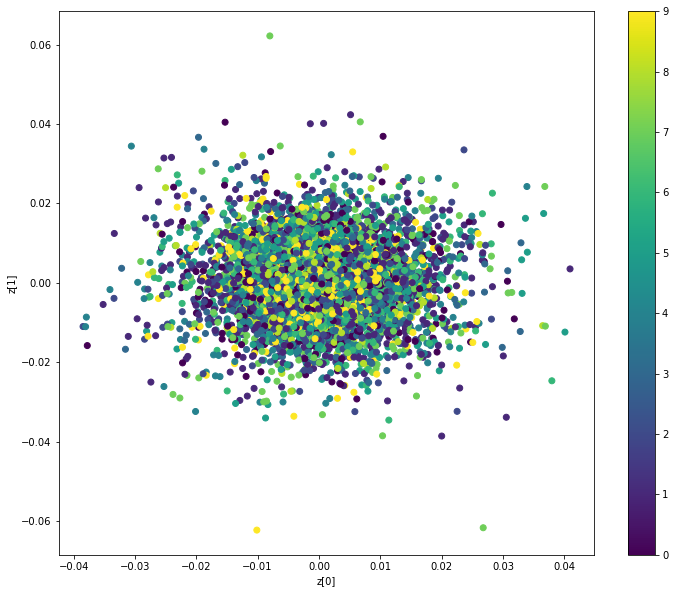

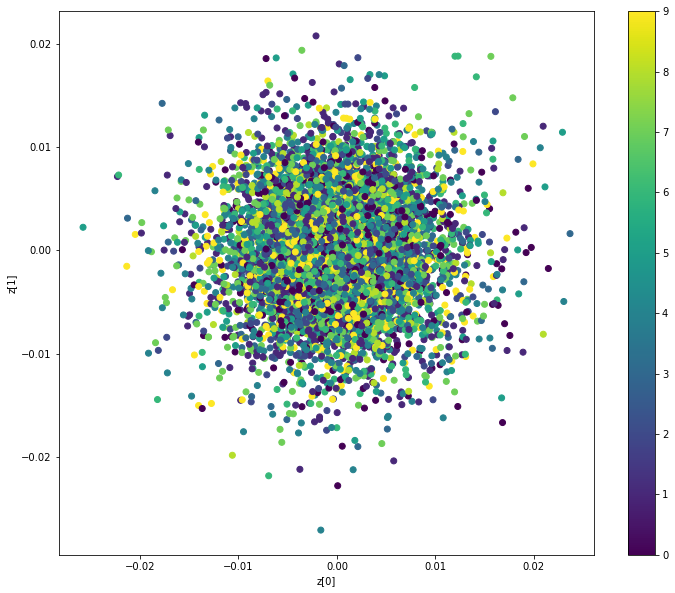

In [ ]:
for keys, values in reconstructed_images.items():
    title_list = keys.split("_")
    latent_dim = title_list[1][-1]
    epoch = title_list[3].split(".")[0]

    z_latent_list = values["latent_representation"]
    labels_list = values["labels"]

    plot_label_clusters(z_latent_list, labels_list)

## b) Plot 15 reconstructed digits and the corresponding original ones.

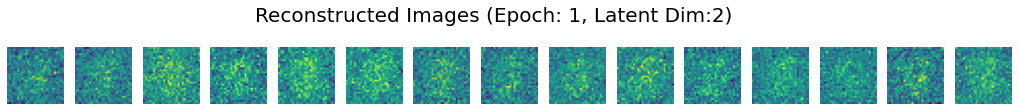

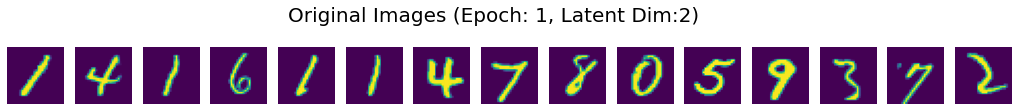

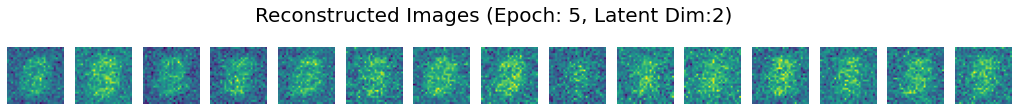

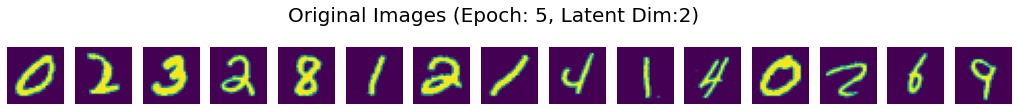

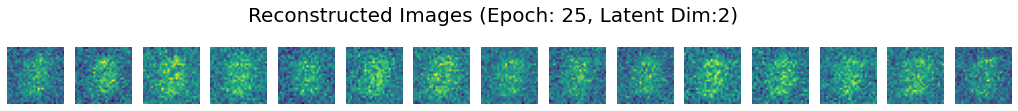

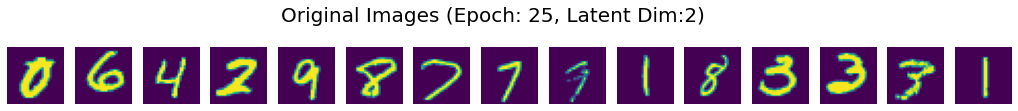

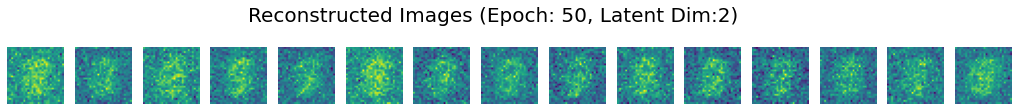

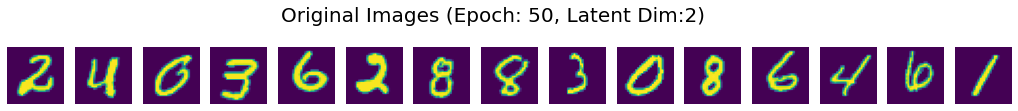

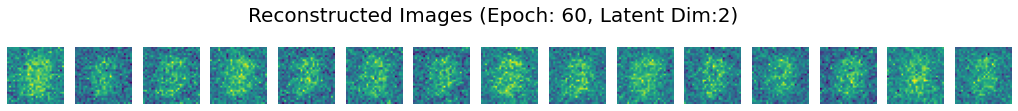

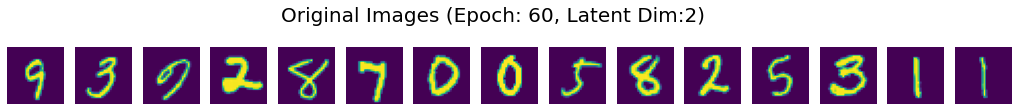

In [ ]:
for keys, values in reconstructed_images.items():
    title_list = keys.split("_")
    latent_dim = title_list[1][-1]
    epoch = title_list[3].split(".")[0]

    plot_img_data(values["recon_images"], "Reconstructed Images", epoch, latent_dim)


    plot_img_data(values["original_images"], "Original Images", epoch, latent_dim)

## c) Plot 15 generated digits, i.e., decode 15 samples from the prior.

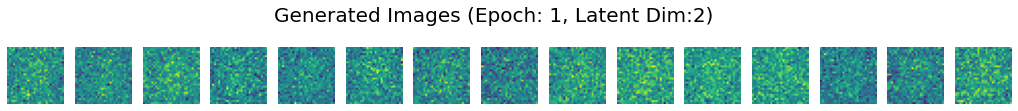

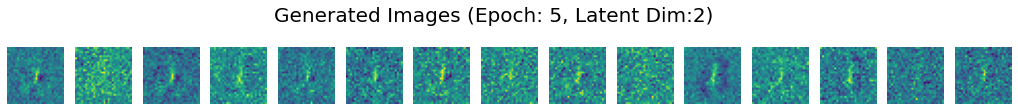

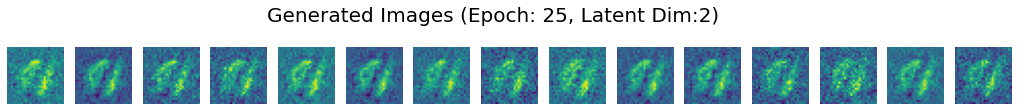

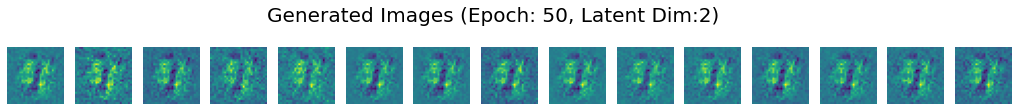

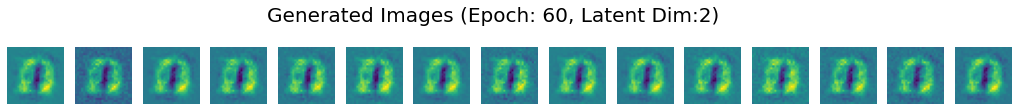

In [ ]:
for keys, values in reconstructed_images.items():
    title_list = keys.split("_")
    latent_dim = title_list[1][-1]
    epoch = title_list[3].split(".")[0]

    plot_img_data(values["generated_images"], "Generated Images", epoch, latent_dim)

# 4) Plot the loss curve (test set), i.e., epoch vs. -L(ELBO).

In [ ]:
dataframe = pd.DataFrame(test_loss_list, columns=["Loss"])
dataframe["Epochs"] = dataframe.index.values
dataframe.head(3)

Loss  Epochs
0  2.064063       0
1  0.356823       1
2  0.324878       2

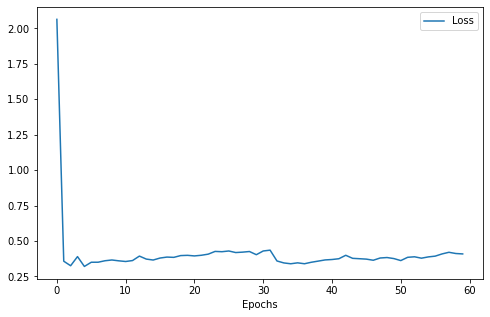

In [ ]:
dataframe.plot(x="Epochs", y="Loss", figsize=(8,5))

#5 Train the VAE using a 32-dimensional latent space and do the following experiments after the optimisation converged:

## 5_MODEL BUILDING

In [ ]:
# Define the encoder network
class Encoder(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=256, latent_dim=32):
        super().__init__()

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.mean = nn.Linear(hidden_dim, latent_dim)
        self.log_std = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        mean = self.mean(x)
        log_std = torch.exp(self.log_std(x))
        return mean, log_std

In [ ]:
# Define the decoder network
class Decoder(nn.Module):
    def __init__(self, latent_dim=32, hidden_dim=256, output_dim=784):
        super().__init__()

        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.mean = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        batch_dim = x.shape[0]
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        mean = self.mean(x)
        return mean


In [ ]:
# Define the VAE
class VAE(nn.Module):

    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.posterior_std = nn.Parameter(torch.tensor(1.0), requires_grad=True)
        self.device = device
        
    def forward(self, x):
        # Encode the input data
        # z = z_mean + torch.exp(0.5 * z_log_std)*self.N.sample(z_mean.shape)
        z_mean, z_log_std = self.encoder(x)
        self.batch_size = z_mean.shape[0]
        self.z_mean = z_mean
        self.z_log_var = z_log_std**2

        cov = torch.einsum("bi,ij -> bij", self.z_log_var, torch.eye(32, device=device))
        z_latent = torch.distributions.MultivariateNormal(z_mean, cov).sample()

        z_prior = self.make_prior(32, self.batch_size ).sample()

        # Decode the latent representation
        posterior_mean = self.decoder(z_latent)

        return z_latent, z_prior, posterior_mean
    
    def vae_loss(self, z_latent, z_prior, posterior_mean, kl_loss_function, batch_data):

        # maybe we will use this one
        #kl_loss = kl_loss_function(z_latent, z_prior).sum(axis=1)

        #kl loss implementation
        kl_loss = -0.5 * (1 + self.z_log_var - torch.square(self.z_mean) - torch.exp(self.z_log_var))
        kl_loss = kl_loss.sum(axis=1)


        cov = model.posterior_std**2 * torch.eye(784, device=device)
        likelihood_loss = torch.distributions.MultivariateNormal(posterior_mean, cov).log_prob(torch.flatten(batch_data, start_dim = 1).to(device))

        elbo = torch.mean(likelihood_loss - kl_loss)

        # Return the negative elbo
        return -elbo

    def make_prior(self, dim_latent_space, batch_size):
        mean = torch.zeros(batch_size, dim_latent_space, device=device)
        cov = torch.eye(dim_latent_space, device=device).repeat(batch_size, 1, 1)
        return torch.distributions.MultivariateNormal(mean, cov)


## 5_TRAINING

In [ ]:
# Create the encoder and decoder networks
encoder = Encoder()
decoder = Decoder()

# Create the VAE
model = VAE(encoder, decoder,device).to(device)

In [ ]:
%%time

num_epochs=60
latent_dim = 32
# Define the optimizer and learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
kl_loss = nn.KLDivLoss(reduction="none").to(device)
train_loss_list = []
test_loss_list = []
# Train the VAE
for epoch in range(1, num_epochs+1):

    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        
        # Run VAE
        z_latent, z_prior, posterior_mean = model(data)
        
        # Compute loss
        total_loss = model.vae_loss(z_latent, z_prior, posterior_mean, kl_loss, data)
        total_loss.backward()
        train_loss += total_loss.item()
        optimizer.step()

        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tposterior_std: {:f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                total_loss.item() / len(data),
                model.posterior_std.item()))
        
    if epoch==1:
      torch.save(model.state_dict(), f"model_latent{latent_dim}_epoch_{epoch}.model")
    if epoch==5:
      torch.save(model.state_dict(), f"model_latent{latent_dim}_epoch_{epoch}.model")
    if epoch==25:
      torch.save(model.state_dict(), f"model_latent{latent_dim}_epoch_{epoch}.model")
    if epoch==50:
      torch.save(model.state_dict(), f"model_latent{latent_dim}_epoch_{epoch}.model")
    
    train_loss /=  len(train_loader.dataset)
    print('====> Epoch: {} Average Train loss: {:.4f}'.format(epoch, train_loss))
    train_loss_list.append(train_loss)

    model.eval()
    test_loss = 0
    for batch_idx, (data, _) in enumerate(test_loader):
        data = data.to(device)        
        # Run VAE
        z_latent, z_prior, posterior_mean = model(data)
        
        # Compute loss
        total_loss = model.vae_loss(z_latent, z_prior, posterior_mean, kl_loss, data)
        test_loss += total_loss.item()
    
    test_loss /=  len(test_loader.dataset)
    print('====> Epoch: {} Average Test loss: {:.4f}'.format(epoch, test_loss))
    print()
    test_loss_list.append(test_loss)

torch.save(model.state_dict(), f"model_latent{latent_dim}_epoch_{epoch}.model")

Train Epoch: 1 [0/60000 (0%)]	Loss: 6.094991	posterior_std: 0.999000
Train Epoch: 1 [25600/60000 (43%)]	Loss: 4.518564	posterior_std: 0.790390
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.756281	posterior_std: 0.562210
====> Epoch: 1 Average Train loss: 4.1518
====> Epoch: 1 Average Test loss: 2.0416

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.054582	posterior_std: 0.479391
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.291326	posterior_std: 0.275393
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.166705	posterior_std: 0.254097
====> Epoch: 2 Average Train loss: 0.6074
====> Epoch: 2 Average Test loss: 0.2607

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.179346	posterior_std: 0.253267
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.210979	posterior_std: 0.251845
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.344932	posterior_std: 0.251595
====> Epoch: 3 Average Train loss: 0.2501
====> Epoch: 3 Average Test loss: 0.2608

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.282308	posterior_std: 0.251630
Train Epoch: 4 [25600/60000 

## A)

In [ ]:
%%time
# Test the VAE
models = [x for x in os.listdir() if "latent32" in x]

encoder = Encoder()
decoder = Decoder()

reconstructed_images ={}

for model_path in models:
    reconstructed_images[model_path] ={}

    z_latent_list =[]
    labels_list = []
    model = VAE(encoder, decoder,device).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    to_be_reconstructed = torch.tensor([], device =model.device)
    test_loss = 0
    for batch_idx, (data, labels) in enumerate(test_loader):
        data = data.to(device)
        labels_list.extend(labels.cpu().detach().numpy())        

        # Run VAE
        z_latent, _, _ = model(data)
        z_latent_list.extend(z_latent.cpu().detach().numpy())

    reconstructed_images[model_path]["latent_representation"] = np.array(z_latent_list)
    reconstructed_images[model_path]["labels"] = np.array(labels_list)

    #PART B
    recon_images_list = []
    original_images_list = []

    for index in range(15):
        data_point = data[index]
        original_images_list.append(data_point.squeeze(2).cpu().detach().numpy())
        data_point = data_point.unsqueeze(0)
        recon_images_list.append(reconstruct_digit(model, data_point))

    reconstructed_images[model_path]["recon_images"] = recon_images_list
    reconstructed_images[model_path]["original_images"] = original_images_list

    #PART C
    generated_images_list = []
    for index in range(15):
        latent_data = torch.distributions.MultivariateNormal(torch.zeros(32, device=model.device), torch.eye(32,device=model.device)).sample()
        generated_images_list.append(generate_digit(model, latent_data))
    
    reconstructed_images[model_path]["generated_images"] = generated_images_list

CPU times: user 2.04 s, sys: 23.1 ms, total: 2.06 s
Wall time: 2.06 s


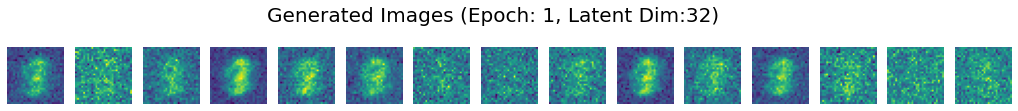

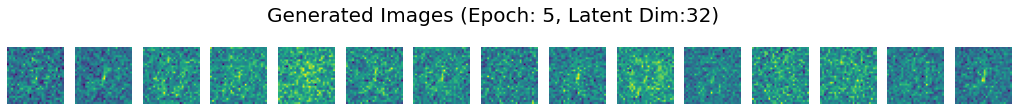

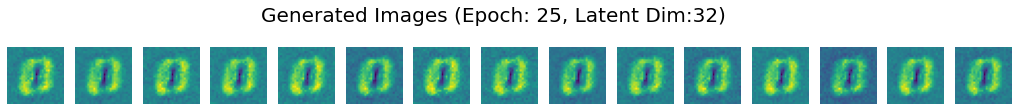

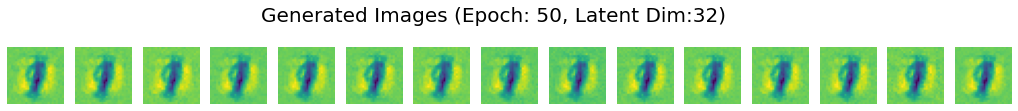

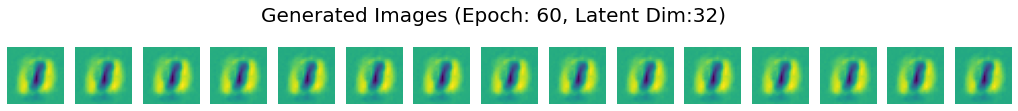

In [ ]:
for keys, values in reconstructed_images.items():
    title_list = keys.split("_")
    latent_dim = title_list[1][-2:]
    epoch = title_list[3].split(".")[0]

    plot_img_data(values["generated_images"], "Generated Images", epoch, latent_dim)

## B)

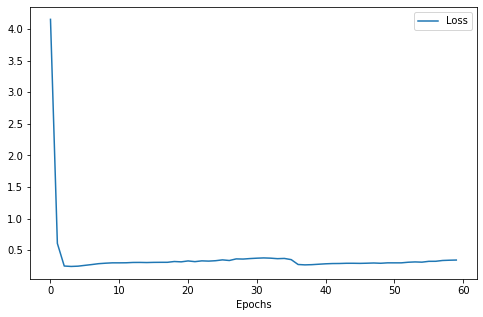

In [ ]:
dataframe = pd.DataFrame(train_loss_list, columns=["Loss"])
dataframe["Epochs"] = dataframe.index.values
dataframe.plot(x="Epochs", y="Loss", figsize=(8,5))